# Misc dithering

In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

uint8
216


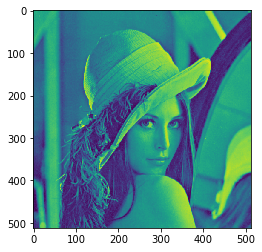

In [4]:
im = cv2.imread('assets/images/lena.png', cv2.IMREAD_GRAYSCALE)

print(im.dtype)
print(len(np.unique(im)))

plt.imshow(im, cmap='gray', interpolation='none')

In [86]:
def nearest_val(val, palette):
    """Find the value in the palette closest to val"""
    return palette[np.argmin(np.abs(val - palette))]

First, let us try to binarize it with a global threshold. This is not a good idea.

True

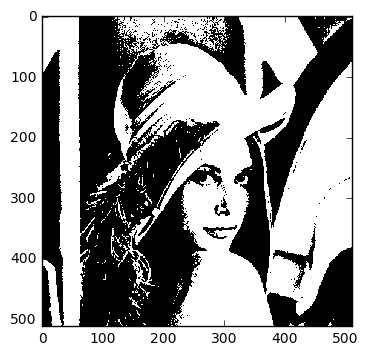

In [98]:
glob_bin_im = 255*(im > 127)

plt.imshow(glob_bin_im, cmap='gray', interpolation='none')
cv2.imwrite('assets/images/lena_bin_glob.png', glob_bin_im)

Instead, we could try to use ordered dithering.

In [88]:
def binary_dither(im, d_n):
    """Apply a dithering algorithm to a grayscale image to make it binary
    (black and white) while retaining percieved detail
    
    Args:
        im: 2D numpy array of uint8. Input image.
        d_n: 2^n x 2^n numpy array of uint8. Dither matrix containing (2^n)^n
             equidistant values in the [0, 255] range
    Returns:
        new_im: 2D numpy array in {0, 255}. 2^n times the size of im in each direction
    """
    
    h, w = im.shape
    n = int(np.log2(d_n.shape[0]))
    assert(2**n == d_n.shape[0])
    
    new_im = np.zeros((h*(2**n), w*(2**n)), dtype=np.uint8)
    
    for i in range(h):
        for j in range(w):
            new_i = i*(2**n)
            next_i = (i + 1)*(2**n)
            new_j = j*(2**n)
            next_j = (j + 1)*(2**n)
            
            new_im[new_i:next_i, new_j:next_j] = 255*(im[i, j] > d_n)
            
    return new_im

This should look more like the original.

True

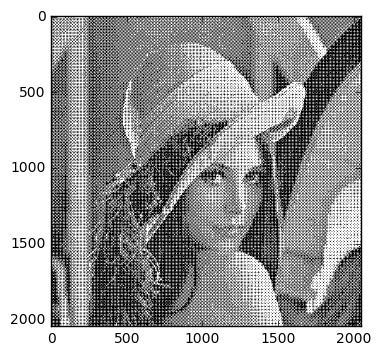

In [96]:
d_2 = np.array([[0,   128,  32, 160],
                [192,  64, 224,  96],
                [48,  176,  16, 144],
                [240, 112, 208,  80]])

bin_im = binary_dither(im, d_2)

plt.imshow(bin_im, cmap='gray')
cv2.imwrite('assets/images/lena_bin_dither.png', bin_im)

Nice, let us also try the Floyd Steinberg error diffusion method.

In [103]:
def error_diffusion(im):
    """Perform binary Floyd-Steinberg dithering algorithm"""
    palette = [0, 255]
    m, n = im.shape
    new_im = im.copy()
    
    for i in range(m):
        for j in range(n):
            old_val = new_im[i, j]
            new_val = nearest_val(old_val, palette)
            new_im[i, j] = new_val
            quant_error = old_val - new_val
            if i+1 < m:
                new_im[i+1, j-1] += int(quant_error*3/16)
                new_im[i+1, j] += int(quant_error*5/16)
                if j+1 < n:
                    new_im[i+1, j+1] += int(quant_error*1/16)
            if j+1 < n:
                new_im[i, j+1] += int(quant_error*7/16)
    
    return new_im.astype(np.uint8)

True

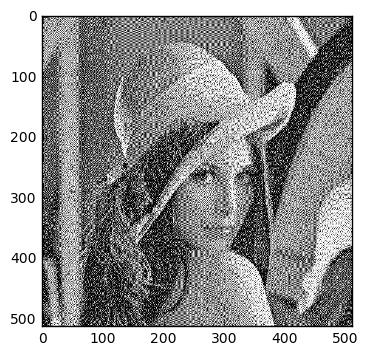

In [104]:
bin_im_diffusion = error_diffusion(im)

plt.imshow(bin_im_diffusion, cmap='gray')
cv2.imwrite('assets/images/lena_error_diffusion.png', bin_im_diffusion)

In [92]:
def nearest_quantization(im, num_gl):
    """Requantize an image where each pixel is assigned a value according
    to a equidistant sample of graylevels"""
    palette = np.linspace(0, 255, num_gl) # Assume 255 is max value
    m, n = im.shape
    
    new_im = np.array([[nearest_val(im[i, j], palette) for j in range(n)] for i in range(m)])
    
    return new_im

In [93]:
def nearest_quantization_dither16(im, num_gl):
    """Requantize an image to 16 graylevels"""
    palette = np.linspace(0, 255, num_gl) # Assume 255 is max value
    d_2 = np.array([[0, 128, 32, 160],
                    [192, 64, 224, 96],
                    [48, 176, 16, 144],
                    [240, 112, 208, 80]])/256 - 8
    m, n = im.shape
    
    new_im = np.array([[nearest_val(im[i, j] + d_2[np.mod(i, 4), np.mod(j, 4)], palette) for j in range(n)] for i in range(m)])
    
    return new_im

[  17.   34.   51.   68.   85.  102.  119.  136.  153.  170.  187.  204.
  221.  238.]
[  17.   34.   51.   68.   85.  102.  119.  136.  153.  170.  187.  204.
  221.  238.]


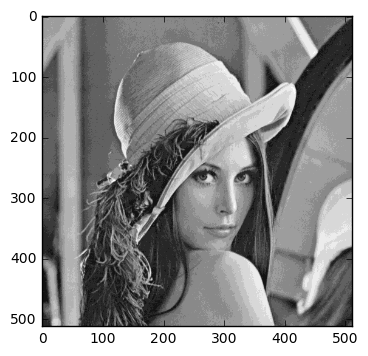

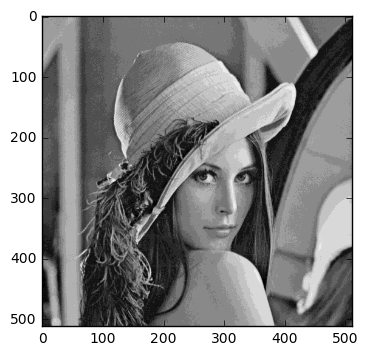

In [94]:
num_gl = 16

nearest_im = nearest_quantization(im, num_gl)
dither_im = nearest_quantization_dither16(im, num_gl)

plt.figure(0)
plt.imshow(nearest_im, cmap='gray')

plt.figure(1)
plt.imshow(dither_im, cmap='gray')

print(np.unique(nearest_im))
print(np.unique(dither_im))